# 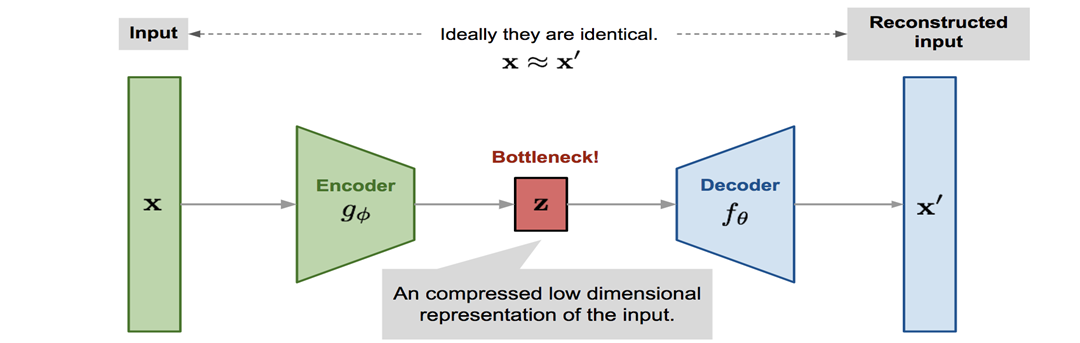

Autoencoders are neural networks that have the ability to discover low-dimensional representations of high-dimensional data. From this, it should be able to reconstruct the input from the output.

Autoencoder Architecture has 3 major parts: 
    An Encoder, which reduces the dimensionality of a high dimensional dataset to a low dimensional one. 
    Code, which contains the reduced representation of the input that is fed into the decoder. 
    A Decoder which expands the low-dimensional data to high-dimensional data.

The idea is straightforward:
    Due to the bottleneck architecture of the neural network, it is forced to learn a condensed representation from which to    reproduce the original input.
    We generally need to feed it with normal data, which it will learn to reproduce with high fidelity.
    As a consequence, if an abnormal data is sufficiently distinct from normal data, the autoencoder will have trouble reproducing it with its learned weights, and the subsequent reconstruction loss will be high. Anything above a specific loss (treshold) will be flagged as anomalous and thus labeled as outlier.



ANOMALY DETECTION USING AUTOENCODER

Step1: Import all the required Libraries to build the model

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from scipy.stats import multivariate_normal
%matplotlib inline
#import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from scipy.stats import norm
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard

from datetime import datetime


Step 2: Read the dataset. Fill the missing values with "nan" and get more information about the dataset.

In [2]:
train_df = pd.read_excel("UTIL.xlsx") 
print(train_df.columns.values)
#Fill the empty cells with NAN and then drop them.
for (columnName, columnData) in train_df.iteritems():
    train_df[columnName].replace('', np.nan, inplace=True)

#train_df = train_df.dropna(subset=train_df.columns.values)
train_df.head(5)

['DATETIME' 'IP_NE_NAME' 'INTERFACE_NAME' 'HIGH_SPEED' 'IN_MBPS'
 'OUT_MBPS' 'IN_UTILIZATION' 'OUT_UTILIZATION']


,DATETIME,IP_NE_NAME,INTERFACE_NAME,HIGH_SPEED,IN_MBPS,OUT_MBPS,IN_UTILIZATION,OUT_UTILIZATION
0,2019-08-03 19:50:00,A,port1,1,30.585971,664.577856,3.058597,66.457786
1,2019-08-03 19:55:00,A,port1,1,54.233310,596.307367,5.423331,59.630737
2,2019-08-03 20:00:00,A,port1,1,39.877537,684.610229,3.987754,68.461023
3,2019-08-03 20:05:00,A,port1,1,48.926120,645.870733,4.892612,64.587073
4,2019-08-03 20:10:00,A,port1,1,45.356221,600.891337,4.535622,60.089134


Step 3: Fill the "nan" values with centeral differencing: train_df.loc[i,col] = (train_df.loc[i+1,col]+train_df.loc[i-1,col])/2. In case the next value is nan, we assume the next value is 0.

In [3]:
print('Before interpolation:')
print(train_df.isna().sum(),'\n')
for col in train_df.columns[3:]:
    for i in range(1,len(train_df)-1):
        if str(float(train_df[col].loc[i])).lower()=='nan':
            prev    = train_df[col].loc[i-1]
            if str(float(train_df[col].loc[i+1])).lower()=='nan':
                nextval = 0
            else:
                nextval = train_df[col].loc[i+1]
            train_df.loc[i,col] = ((nextval+prev)/2)
print('After interpolation:')
print(train_df.isna().sum(),'\n')         
#train_df.to_csv('wothoutnan.csv')

Before interpolation:
DATETIME             0
IP_NE_NAME           0
INTERFACE_NAME       0
HIGH_SPEED           0
IN_MBPS            172
OUT_MBPS           255
IN_UTILIZATION     172
OUT_UTILIZATION    255
dtype: int64 

After interpolation:
DATETIME           0
IP_NE_NAME         0
INTERFACE_NAME     0
HIGH_SPEED         0
IN_MBPS            0
OUT_MBPS           0
IN_UTILIZATION     0
OUT_UTILIZATION    0
dtype: int64 



Step 4: Plot data distributation.

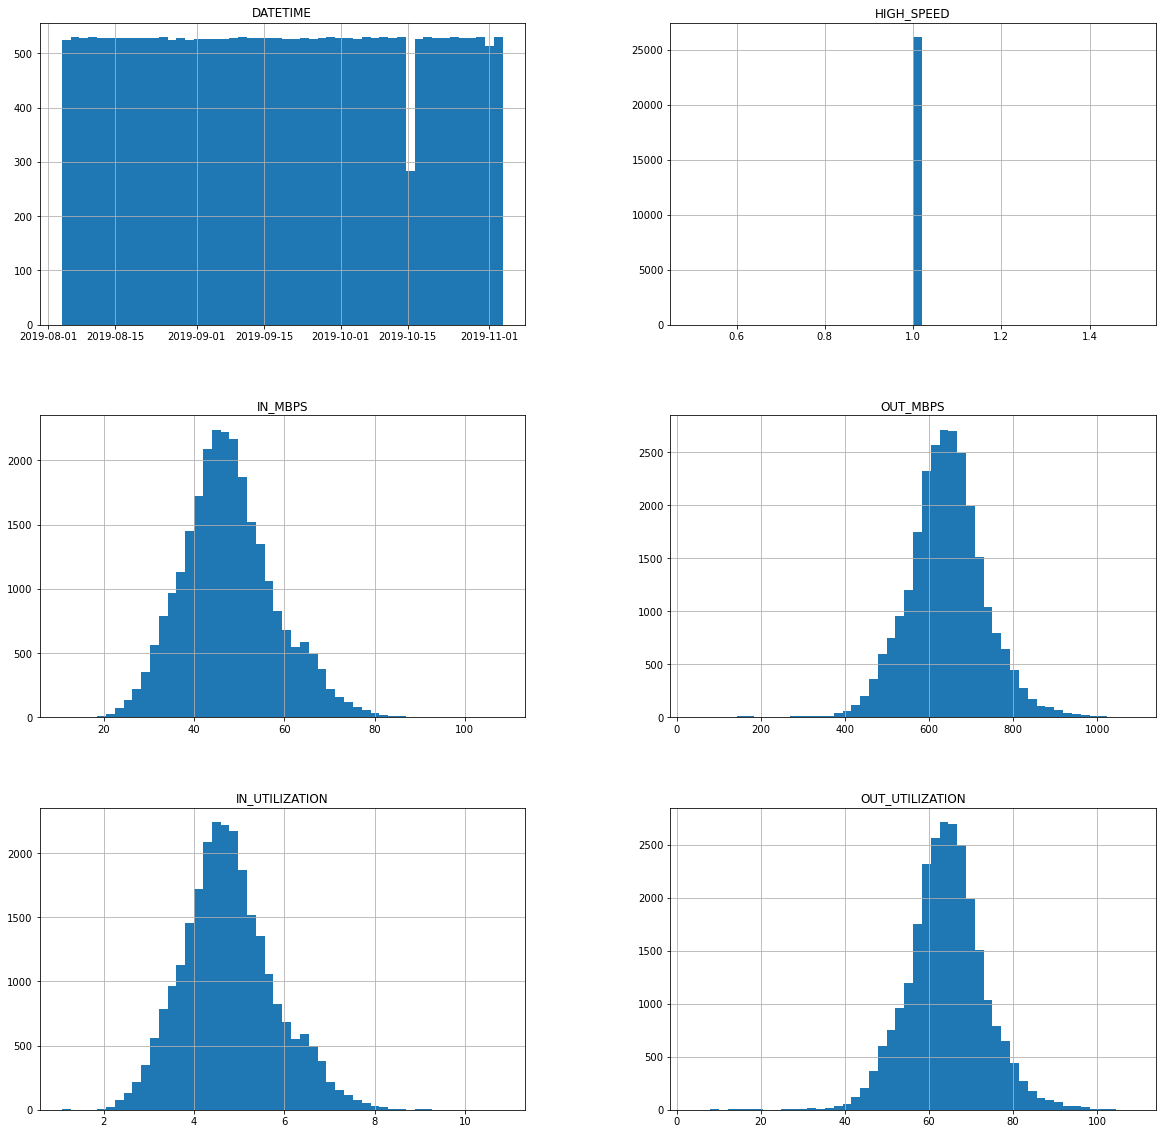

In [4]:
train_df.hist(bins = 50, figsize = (20,20))
plt.show()

Step 5: Get the "OUT_UTILIZATION" data from the original data.

In [5]:
# Set the starting day for the training period, and the deltas
X=train_df.iloc[:,7]

#X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)


Step 6: Z-score normalization.

In [6]:
X_mean = X.mean()
X_std = X.std()
x = (X - X_mean) / X_std
#print("Number of training samples:", len(x))

Step 7: Prepare training data
Get "DATETIME" from the training timeseries data and normalize "OUT_UTILIZATION" from "x". We have a value for every 5 mins for 3 months from 03/08-03/11 (92 days). Create sequences windows in daily basis.

24(hour) * 60(min) / 5 (data recorded every 5 min ) = 288 timesteps per day

In [7]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

date=train_df.iloc[:,0]

x_train = create_sequences(x.values)
date_train = create_sequences(date.values)

The data now has 25870 windows with 288 samples. Note that last 287 samples in "DATETIME" and "OUT_UTILIZATION" cannot generate windows as they cannot generate 288 samples per sequence. Number of training samples: 26157 and sequence windows has size of (25870, 288).

In [8]:
print("Number of training samples:", len(X))
print("Training input shape: ", x.shape)
print("Training input shape: ", x_train.shape) 
print("Training input shape: ", date_train.shape)

Number of training samples: 26157
Training input shape:  (26157,)
Training input shape:  (25870, 288)
Training input shape:  (25870, 288)


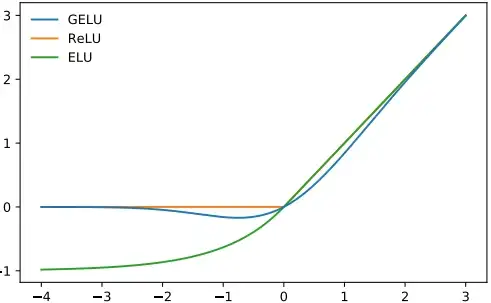
In this workshop, we will design autoencoder and CNN autoencoder models with different activation functions such as ELU, ReLU and GAUSSIAN ERROR LINEAR UNIT (GELU). 

Classical activation functions:
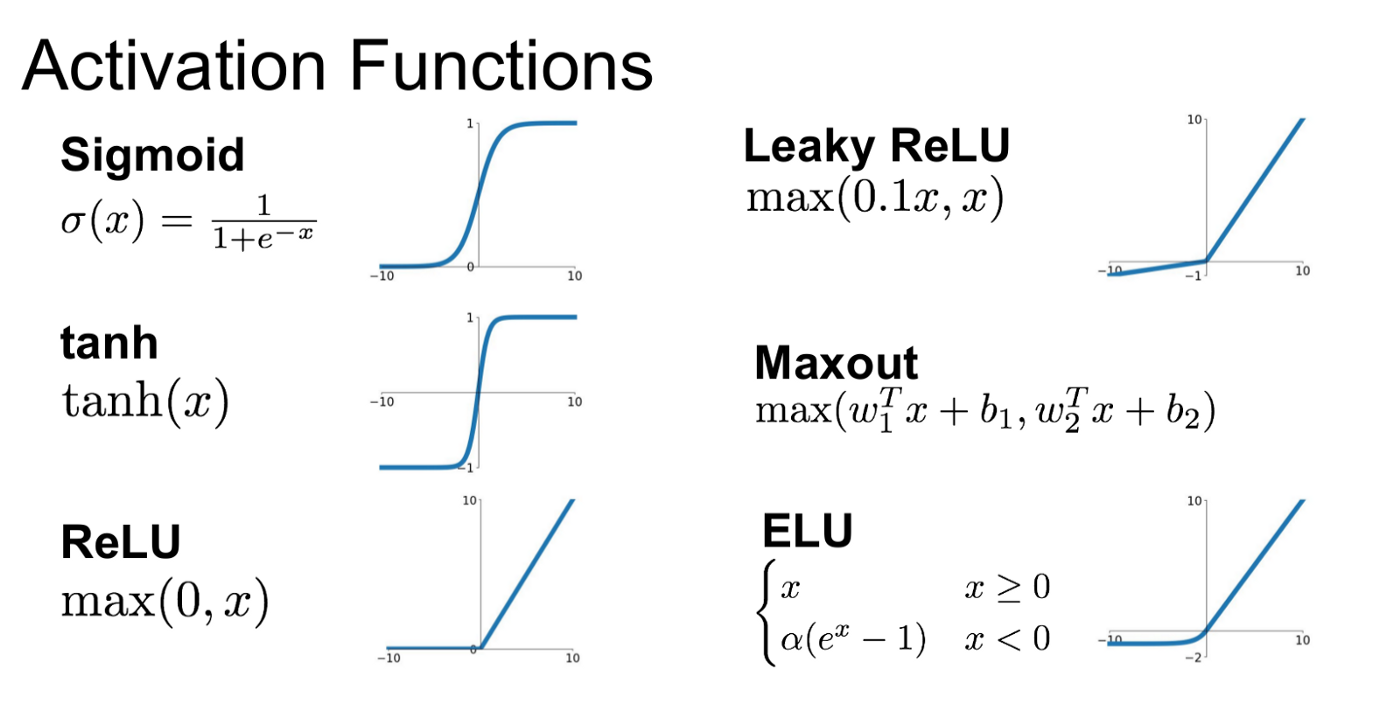


The GELU activation function can be written mathematically as follow:

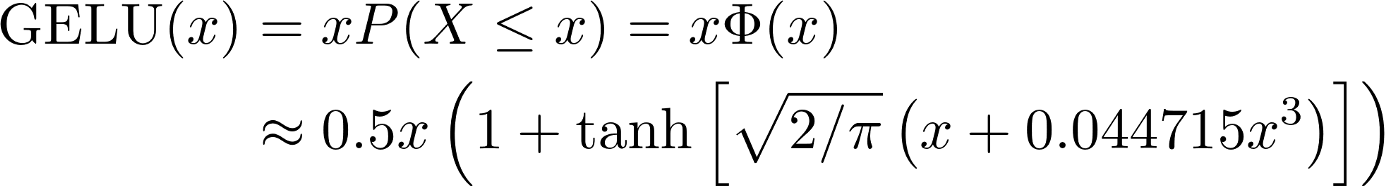

Step 8: Implement GELU activation function.

In [9]:
def gelu(inp):
    #Gaussian Error Linear Unit.
    cdf = 0.5 * (1.0 + tf.tanh(
        (np.sqrt(2 / np.pi) * (inp + 0.044715 * tf.pow(inp, 3)))))
    return inp * cdf

The autoencoder is attempting to learn an approximation such that x is similar to xpred. It means, it is trying to attain the lowest possible reconstruction error E (x, xpred) that measure the discrepancy between x and xpred . Hence the following equation is obtained E(x, xpred)=||x-xpred||.

Autoencoders were mainly developed as a multi-layer perceptron.

Step 9 (a): The first autoencoder model is with ELU activation function and consists of:


a) Encoder:

1) Input layer with 288 neurons

2) first hidden layer with 32 neurons

3) second hidden layer with 16 neurons

4) third hidden layer with 8 neurons



b) Bottleneck:

1) hidden layer with 4 neurons


c) Decoder:

1) first hidden layer with 8 neurons

2) second hidden layer with 16 neurons

3) third hidden layer with 32 neurons

4) Output layer with 288 nerons

In [40]:
# data dimensions // hyperparameters 
input_dim = x_train.shape[1]
BATCH_SIZE = 288
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='gelu', input_shape=(input_dim, )),
    tf.keras.layers.Dense(32, activation='gelu'),
    tf.keras.layers.Dense(16, activation='gelu'),
    tf.keras.layers.Dense(8, activation='gelu'),
    
    # Bottleneck / CODE
    tf.keras.layers.Dense(4, activation='gelu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(8, activation='gelu'),
    tf.keras.layers.Dense(16, activation='gelu'),
    tf.keras.layers.Dense(32, activation='gelu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
autoencoder.summary();

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 288)               83232     
                                                                 
 dense_19 (Dense)            (None, 32)                9248      
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dense_21 (Dense)            (None, 8)                 136       
                                                                 
 dense_22 (Dense)            (None, 4)                 36        
                                                                 
 dense_23 (Dense)            (None, 8)                 40        
                                                                 
 dense_24 (Dense)            (None, 16)               

Fitting training data


In [42]:
history = autoencoder.fit(
    x_train,
    x_train,
    epochs=500,
    batch_size=288,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/500
81/81 [==============================] - 1s 13ms/step - loss: 0.7412 - val_loss: 1.0676
Epoch 2/500
81/81 [==============================] - 1s 11ms/step - loss: 0.7407 - val_loss: 1.0663
Epoch 3/500
81/81 [==============================] - 1s 11ms/step - loss: 0.7403 - val_loss: 1.0655
Epoch 4/500
81/81 [==============================] - 1s 10ms/step - loss: 0.7398 - val_loss: 1.0667
Epoch 5/500
81/81 [==============================] - 1s 10ms/step - loss: 0.7394 - val_loss: 1.0673
Epoch 6/500
81/81 [==============================] - 1s 10ms/step - loss: 0.7391 - val_loss: 1.0708
Epoch 7/500
81/81 [==============================] - 1s 10ms/step - loss: 0.7386 - val_loss: 1.0675
Epoch 8/500
81/81 [==============================] - 1s 10ms/step - loss: 0.7382 - val_loss: 1.0666


Calculate reconstruction error and its statistical properties.

In [43]:
reconstructions = autoencoder.predict(x_train)

mse = np.mean(np.power(x_train - reconstructions, 2), axis=1)

# print minimum and maximum of reconstruction error
print("min: {0}".format(min(abs(x_train[:,0]-reconstructions[:,0]))))
print("max: {0}".format(max(abs(x_train[:,0]-reconstructions[:,0]))))
maxx=max(abs(x_train[:,0]-reconstructions[:,0]))
minn=min(abs(x_train[:,0]-reconstructions[:,0]))
# print the mean and variance of reconstruction error
v=np.var(abs(x_train[:,0]-reconstructions[:,0]))
m=sum((abs(x_train[:,0]-reconstructions[:,0])) / len(reconstructions[:,0]))
print("var: {0}".format(v))
print("mean: {0}".format(m))




809/809 [==============================] - 3s 3ms/step
min: 4.4934020029197e-05
max: 6.689016758292095
var: 0.36430432613901526
mean: 0.6733630924000219


Filter the reconstruction error < (max-(mean-7xvar))

In [44]:
thres = "{0:.1f}".format(maxx-(m+7*v)) 
print(float(thres))
outliers = reconstructions[:,0] >1.5
for i in range(0,25870):
    if (abs(x_train[i,0]-reconstructions[i,0])>float(thres)) : 
        outliers[i] = True
    else:
        outliers[i] = False
        
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(reconstructions[:,0]):,} downloads [{np.sum(outliers)/np.size(reconstructions[:,0]):.2%}].")

3.5
Detected 80 outliers in a total of 25,870 downloads [0.31%].


Plot OUT_UTILIZATION and outliers

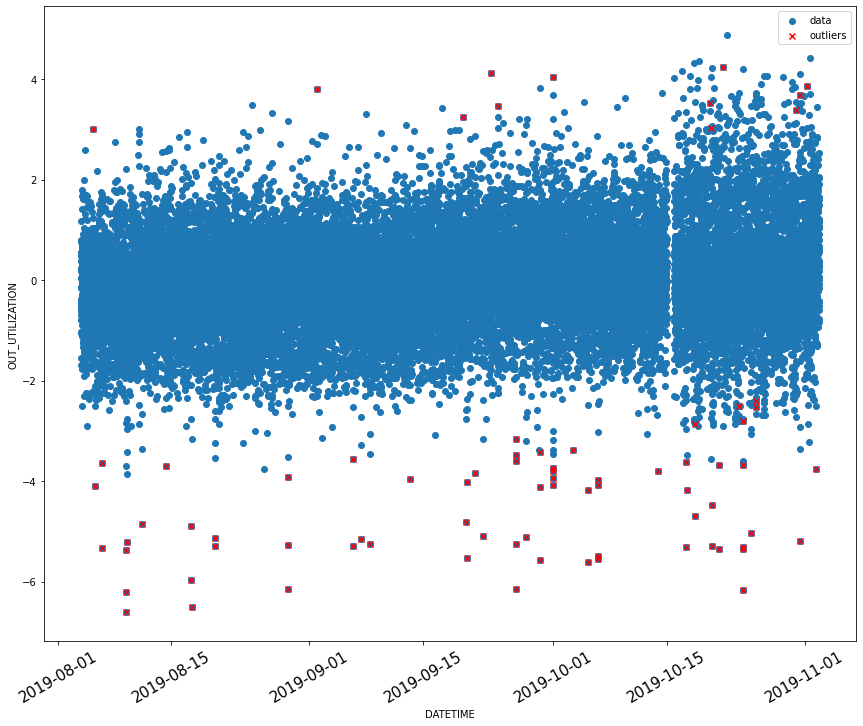

In [45]:
xxdata=x[0:25870]
yydate=date[0:25870]

anomalyg=xxdata[outliers==True]

# Anomalies in dataset
# x-axis: DATETIME   y-axis: OUT_UTILIZATION 
X1 = list(yydate) 
Y = list(xxdata)
# find when the outliers are occurred
tt=date[0:25870]

anomalygx=tt[outliers==True]
# x-axis: DATETIME of Outliers  y-axis: outlires in OUT_UTILIZATION
Xano=list(anomalygx)
Yano=anomalyg
fig=plt.figure(figsize=(12,10))
# plot OUT_UTILIZATION and its outliers
plot=plt.scatter(X1, Y,label="data")
plot=plt.scatter(Xano,Yano, marker='x', color='red',label="outliers")
# Setting Ticks
plt.tick_params(axis='x',labelsize=15,rotation=30)
plt.tight_layout()
plt.xlabel("DATETIME")
plt.ylabel("OUT_UTILIZATION")
plt.legend()
# Display
plt.show()